# 2D ERT processing and inversion with ResIPy
This tutorial performs data processing and ERT inversion with `ResIPy`

## 1. Initialize R2 and design the survey
First we need to import librarie and define paths, electrodes and geometry


In [1]:
datadir = '../data/'
outputdir = '../figures/'
filename= 'trecate'

from resipy import Project
from resipy import R2 # geophysics tools
import numpy as np # matrice operations 
import matplotlib.pyplot as plt

import ERTutils as utils

API path =  /home/alberto/anaconda3/envs/electro/lib/python3.11/site-packages/resipy
ResIPy version =  3.6.1
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


In [2]:
# load dataset
k = R2()
k.createSurvey(datadir + filename+'.csv', ftype='Syscal')

# flat topography
n_elecs = 96
dx = 1.5

elec = np.zeros((n_elecs,3))
elec[:,0] = np.arange(0, n_elecs*dx, dx)
k.setElec(elec)
k.elec.tail()

Working directory is: /home/alberto/anaconda3/envs/electro/lib/python3.11/site-packages/resipy
clearing dirname
filterData: 0 / 7310 quadrupoles removed.
7310/7310 reciprocal measurements found.
238 measurements error > 20 %


,label,x,y,z,remote,buried
91,92,136.5,0.0,0.0,False,False
92,93,138.0,0.0,0.0,False,False
93,94,139.5,0.0,0.0,False,False
94,95,141.0,0.0,0.0,False,False
95,96,142.5,0.0,0.0,False,False


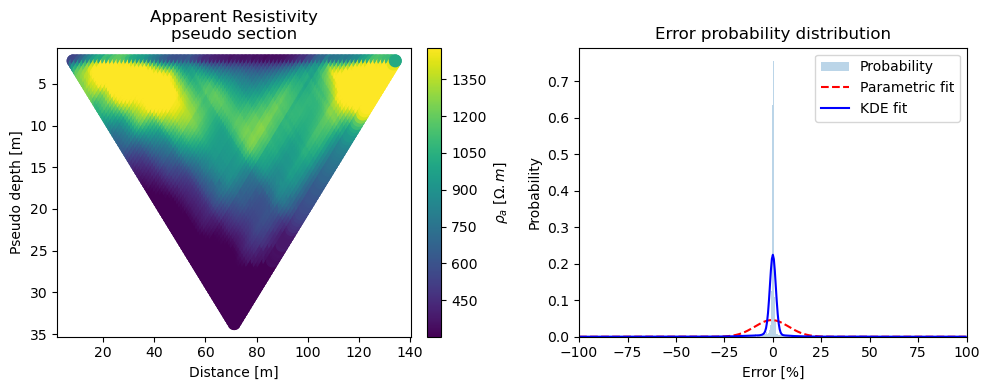

In [3]:
# plot pseudosection and error distribution
fig, ax = plt.subplots(1, 2, figsize=(10,4))
k.showPseudo(ax=ax[0])
k.showErrorDist(ax=ax[1])
fig.tight_layout()

we can now have an overview of the raw data main aspects

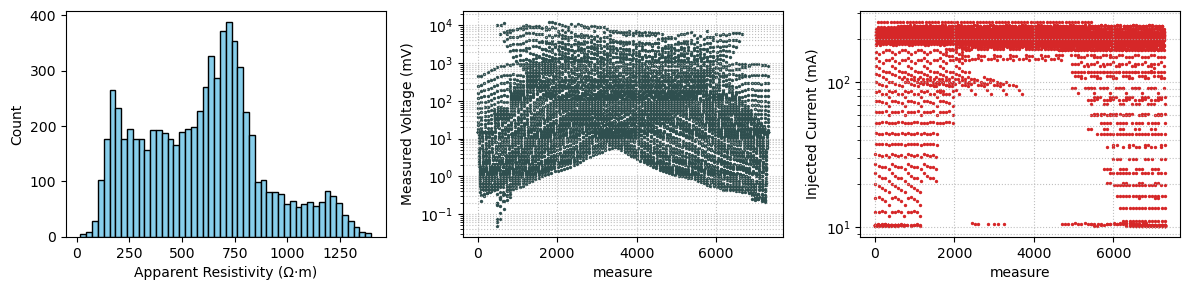

In [4]:
df = k.surveys[0].df # access to the survey database
utils.SurveyStats(df)

## 2. Filtering
We filter the raw data considering the apparent resistivity range 

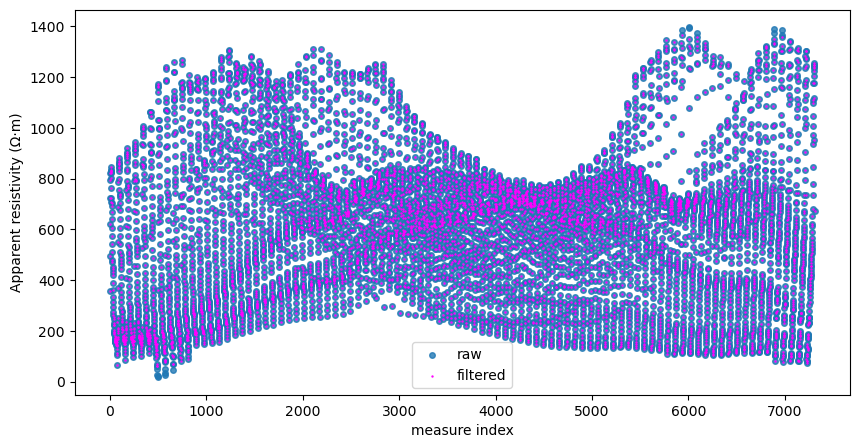

54.56119441557152 1366.1571951835454


In [8]:
rhoa = df["app"].values
measure_idx = np.arange(len(rhoa))  # indice misura
vmin = np.percentile(rhoa, 0.1)
vmax = np.percentile(rhoa, 99.9)
# filtraggio
mask = np.isfinite(rhoa) & (rhoa > vmin) & (rhoa < vmax)
rhoa_filt = rhoa[mask]
measure_idx_filt = measure_idx[mask]

plt.figure(figsize=(10,5))
plt.scatter(measure_idx, rhoa, s=16, c="tab:blue", alpha=0.8, label="raw") # raw
plt.scatter(measure_idx_filt, rhoa_filt, s=.5, c="magenta", alpha=1, label="filtered") # filt

#plt.yscale("log")
plt.xlabel("measure index")
plt.ylabel("Apparent resistivity (Ω·m)")
plt.legend()
plt.show()

print(vmin, vmax)

247 measurements outside [60,1800] removed!


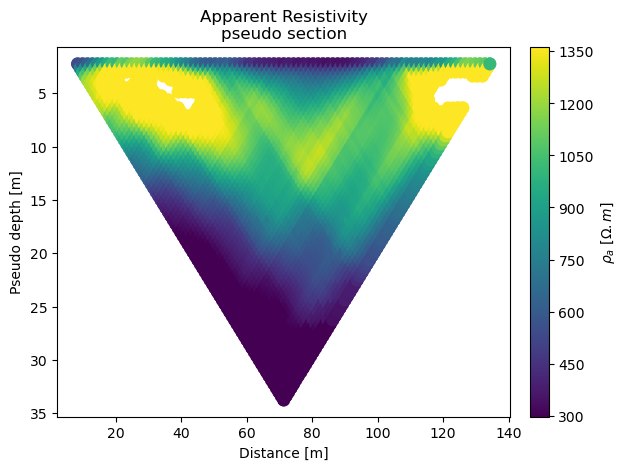

In [9]:
#k.filterUnpaired()
k.filterAppResist(vmin=60, vmax=1800)
k.showPseudo()

now we apply a reciprocals treshold considering the error distribution

filterData: 913 / 7063 quadrupoles removed.
913 measurements with greater than 3.0% reciprocal error removed!


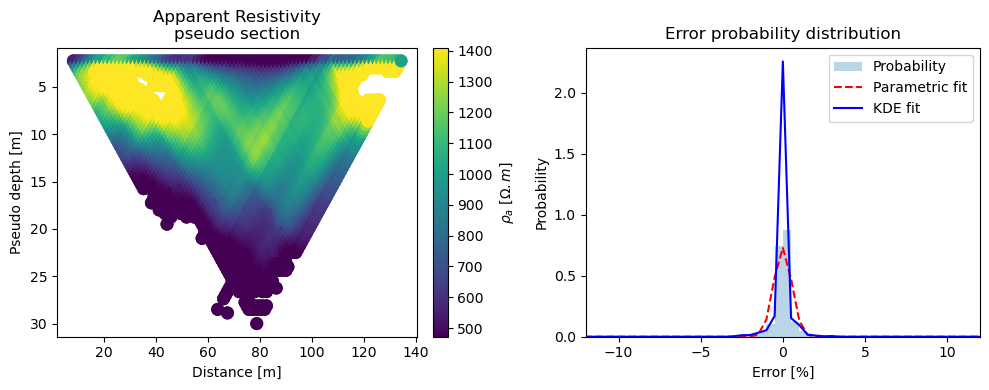

In [10]:
k.filterRecip(percent=3)

# ccheck
fig, ax = plt.subplots(1, 2, figsize=(10,4))
k.showPseudo(ax=ax[0])
k.showErrorDist(ax=ax[1])
fig.tight_layout()

### 2.1 Resistance Error Model

To properly weight the data during inversion, it is essential to estimate the measurement error.  
A common approach is to assume that the error model can be expressed as a combination of absolute error (constant, independent of signal strength) and relative error (proportional to the measured value).  
The collection of direct and reciprocal measurements should, in principle, yield the same apparent resistivity, and their difference provides an empirical estimate of data uncertainty.  
The resistance error $R_{\mathrm{error}}$ for each reciprocal pair is defined as the absolute difference between the normal and reciprocal measurements:

$$
R_{\mathrm{error}} = \lvert R_{\mathrm{normal}} - R_{\mathrm{reciprocal}} \rvert
\tag{1}
$$

The average resistance is computed as:
$$
R_{\mathrm{avg}} = \frac{R_{\mathrm{normal}} + R_{\mathrm{reciprocal}}}{2}
\tag{2}
$$


To derive a general error model, in ResIPy the functions `fitErrorPwl()` (piecewise linear) and `fitErrorLin()` (linear) enable the fitting of direct and reciprocal measurements (Koestel et al., 2008; Mwakanyamale et al., 2012). The fitted law has the form:

- **Linear model:**
  $$
  R_{\mathrm{error}} = a + b \cdot R_{\mathrm{avg}}
  $$

- **Power-law model:**
  $$
  R_{\mathrm{error}} = c \; R_{\mathrm{avg}}^d
  $$

This model directly provides absolute error estimates $(a, c) $ for a given measurement, while the relative error can be obtained by dividing $
\frac{R_{\mathrm{err}}}{R_{\mathrm{avg}}}
$



---

**References**  
- Koestel, J., Kemna, A., Javaux, M., Binley, A., & Vereecken, H. (2008). Quantitative imaging of solute transport in an unsaturated and undisturbed soil monolith with 3D ERT and TDR. *Water Resources Research*, 44(12). https://doi.org/10.1029/2007WR006755  
- Mwakanyamale, K., Slater, L., Binley, A., & Ntarlagiannis, D. (2012). Lithologic imaging using complex conductivity: An example from a sedimentary aquifer. *Near Surface Geophysics*, 10(6), 503–516. https://doi.org/10.3997/1873-0604.2012031

Error model is R_err = 0.002 R_avg^0.950 (R^2 = 0.921)


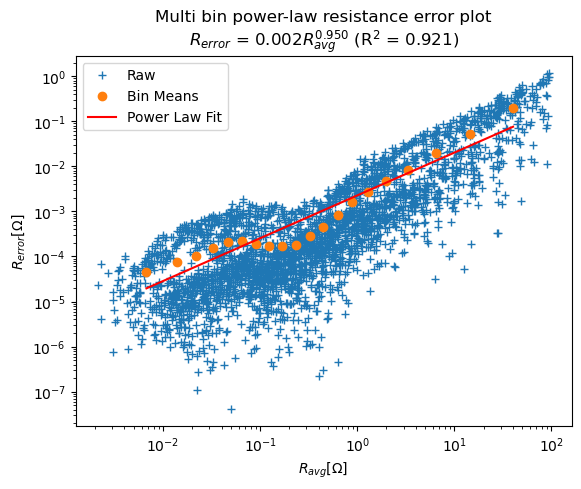

In [11]:
k.fitErrorPwl()

## 3. Mesh

Creating triangular mesh...done (3311 elements)


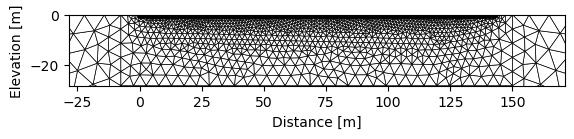

In [12]:
# import electrodes
len_x=(n_elecs-1)*dx
z_doi=len_x/5

k.createMesh(typ='trian', cl=1.2, cl_factor=5, fmd=z_doi)
k.showMesh()

## 4. Inversion

In [13]:
k.param['data_type'] = 1 # using log of resistitivy
k.param['error_mod'] = 2
#k.param['err'] = True
k.param['a_wgt'] = 0.002
k.param['b_wgt'] = 0.035
k.invert()

#k.saveProject(ertdir + 'ert-line1.resipy')

Writing .in file and protocol.dat... done

--------------------- MAIN INVERSION ------------------


0120:fixme:ntdll:EtwEventSetInformation (deadbeef, 2, 0000000145007BE0, 43) stub




 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.10 <<

 >> D a t e : 25 - 09 - 2025
 >> My beautiful survey                                                             
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivity from res0.dat                      
 >> R e g u l a r i s e d   T y p e <<
 >>   L i n e a r    F i l t e r    <<
 >> L o g - D a t a   I n v e r s i o n <<
 >> N o r m a l   R e g u l a r i s a t i o n <<
 >> D a t a   w e i g h t s   w i l l   b e  m o d i f i e d <<


 Processing dataset   1


 Measurements read:  3075     Measurements rejected:     0
   Geometric mean of apparent resistivities:  0.88270E+03

 >> Total Memory required is:          0.084 Gb

   Iteration   1
     Initial RMS Misfit:        57.83       Number of data ignored:     0
     Alpha:         217.106   RMS Misfit:

All ok
0120:fixme:ver:GetCurrentPackageId (00007FFFFE1FEBA0 0000000000000000): stub


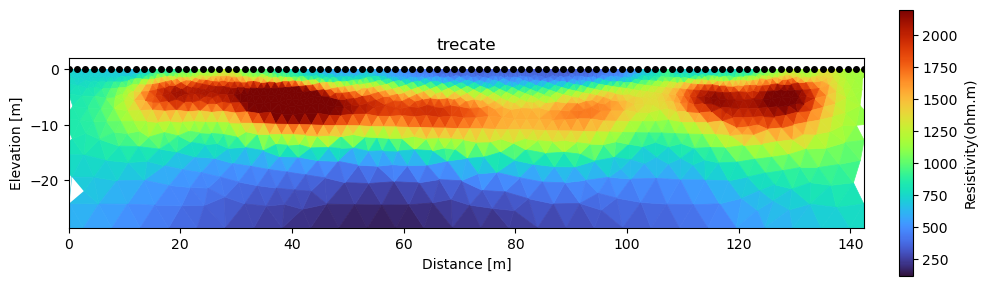

In [35]:
# plot the results
fig, ax = plt.subplots(figsize=(10,3), sharex=True)
k.showResults(index=0, ax=ax,
                 #attr='Resistivity(log10)', vmin=2.1, vmax=3.3,
                 vmin=120, vmax=2200, attr='Resistivity(ohm.m)',
                 #clipCorners=True,
                 #contour=True,
                 color_map='turbo', sens=True
                )
ax.set_xlim(0, len_x)
ax.set_ylim(-z_doi, 2)
ax.set_title(filename)
fig.tight_layout()
#fig.savefig(outputdir +filename +'_model.png', #transparent = True,
           # dpi=200)

# Topography

In [36]:
# load dataset
filename = 'L1'
k = R2()
k.createSurvey(datadir + filename+'.csv', ftype='Syscal')
k.importElec(datadir +'elecs1.txt')
k.elec.head()

Working directory is: /home/alberto/anaconda3/envs/electro/lib/python3.11/site-packages/resipy
clearing dirname
filterData: 0 / 5548 quadrupoles removed.
5548/5548 reciprocal measurements found.
380 measurements error > 20 %


,label,x,y,z,lat,lon,remote,buried
0,1,0.000000,0.0,2584.518000,46.763945,11.037198,False,False
1,2,4.797701,0.0,2585.397815,46.763905,11.037176,False,False
2,3,9.595402,0.0,2585.240009,46.763864,11.037154,False,False
3,4,14.393103,0.0,2584.504856,46.763825,11.037128,False,False
4,5,19.190804,0.0,2584.234036,46.763785,11.037105,False,False


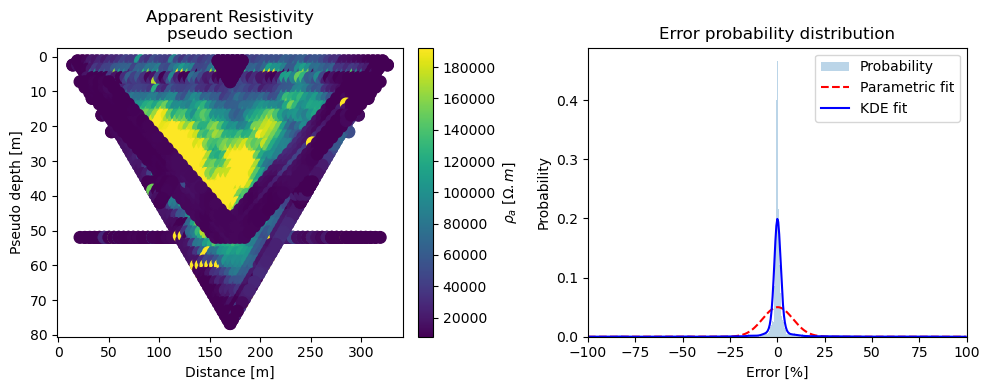

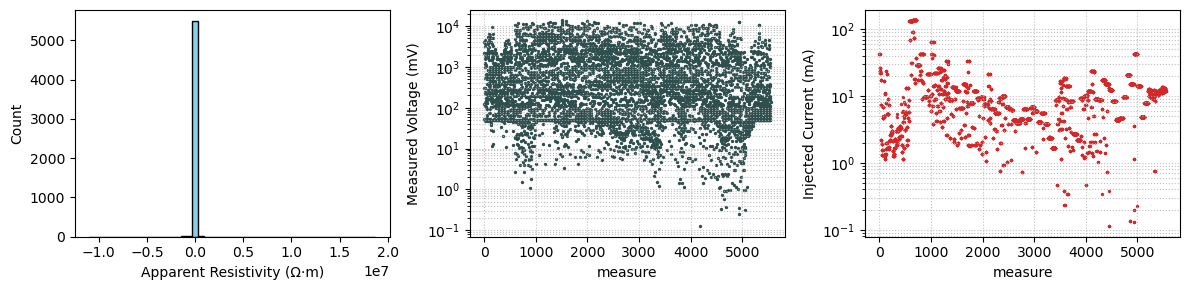

In [39]:
# plot pseudosection and error distribution
fig, ax = plt.subplots(1, 2, figsize=(10,4))
k.showPseudo(ax=ax[0])
k.showErrorDist(ax=ax[1])
fig.tight_layout()

df2 = k.surveys[0].df # access to the data
rhoa = df2["app"].values

utils.SurveyStats(df2)

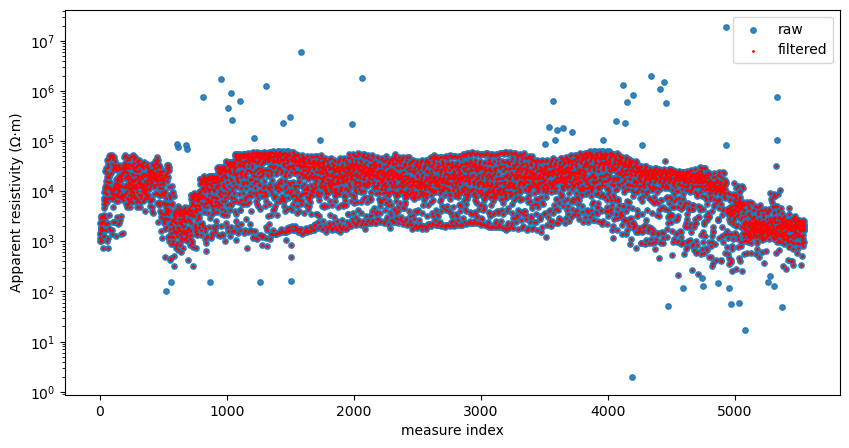

213.5628288049919 61485.361328134604


In [43]:
measure_idx = np.arange(len(rhoa))  # indice misura
vmin = np.percentile(rhoa, 2.5)
vmax = np.percentile(rhoa, 99)
# filtraggio
mask = np.isfinite(rhoa) & (rhoa > vmin) & (rhoa < vmax)
rhoa_filt = rhoa[mask]
measure_idx_filt = measure_idx[mask]

plt.figure(figsize=(10,5))
plt.scatter(measure_idx, rhoa, s=15, c="tab:blue", alpha=0.9, label="raw") # raw
plt.scatter(measure_idx_filt, rhoa_filt, s=1, c="red", alpha=1, label="filtered") # filt

plt.yscale("log")
plt.xlabel("measure index")
plt.ylabel("Apparent resistivity (Ω·m)")
plt.legend()
plt.show()

print(vmin, vmax)

removeUnpaired:filterData: 0 / 5024 quadrupoles removed.
filterData: 0 / 5024 quadrupoles removed.
0 measurements with greater than 10.0% reciprocal error removed!
Error model is R_err = 0.015 R_avg^0.925 (R^2 = 0.990)


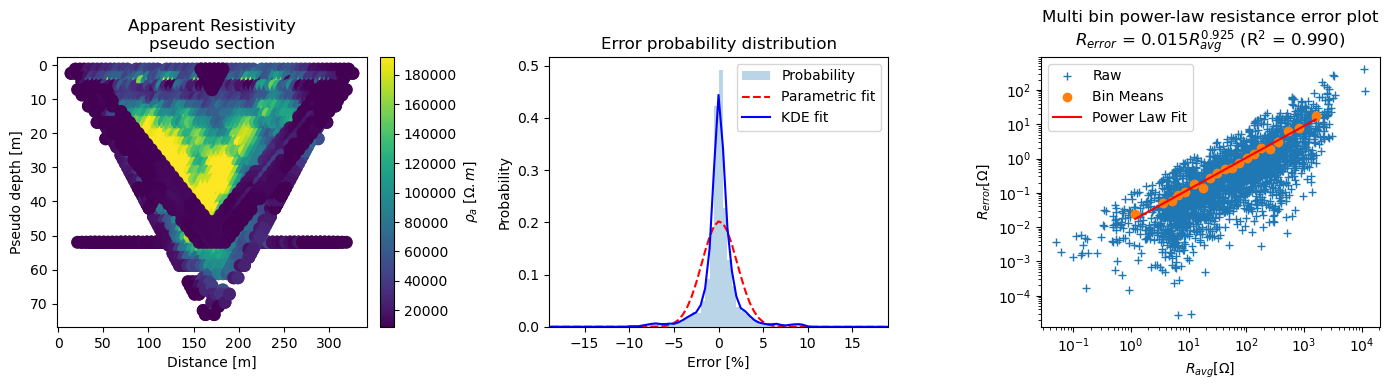

In [46]:
k.filterUnpaired()
k.filterRecip(percent=10)
#k.filterAppResist(vmin=0, vmax=56000)

# ccheck
fig, ax = plt.subplots(1, 3, figsize=(14,4))
k.showPseudo(ax=ax[0])
k.showErrorDist(ax=ax[1])
k.fitErrorPwl(ax=ax[2])
fig.tight_layout()

#k.fitErrPwl()

Creating triangular mesh...done (5054 elements)


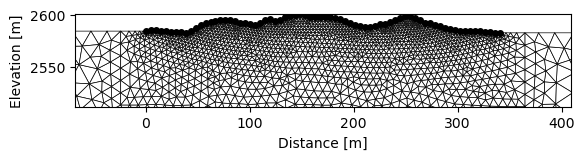

In [50]:
# import electrodes
n_elecs=72
dx=5
len_x=(n_elecs-1)*dx
z_doi=len_x/5

k.createMesh(typ='trian', cl=2.5, cl_factor=5, fmd=z_doi)
k.showMesh()

In [48]:
k.param['data_type'] = 1 # using log of resistitivy
k.param['error_mod'] = 2
#k.param['err'] = True
k.param['a_wgt'] = 0.015
k.param['b_wgt'] = 0.1
k.invert()

#k.saveProject(ertdir + 'ert-line1.resipy')

Writing .in file and protocol.dat... done

--------------------- MAIN INVERSION ------------------


0120:fixme:ntdll:EtwEventSetInformation (deadbeef, 2, 0000000145007BE0, 43) stub




 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.10 <<

 >> D a t e : 25 - 09 - 2025
 >> My beautiful survey                                                             
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivity from res0.dat                      
 >> R e g u l a r i s e d   T y p e <<
 >>   L i n e a r    F i l t e r    <<
 >> L o g - D a t a   I n v e r s i o n <<
 >> N o r m a l   R e g u l a r i s a t i o n <<
 >> D a t a   w e i g h t s   w i l l   b e  m o d i f i e d <<


 Processing dataset   1


 Measurements read:  2512     Measurements rejected:     0
   Geometric mean of apparent resistivities:  0.10405E+06

 >> Total Memory required is:          0.104 Gb

   Iteration   1
     Initial RMS Misfit:        63.45       Number of data ignored:    28
     Alpha:         290.564   RMS Misfit:

All ok
0120:fixme:ver:GetCurrentPackageId (00007FFFFE1FEBA0 0000000000000000): stub


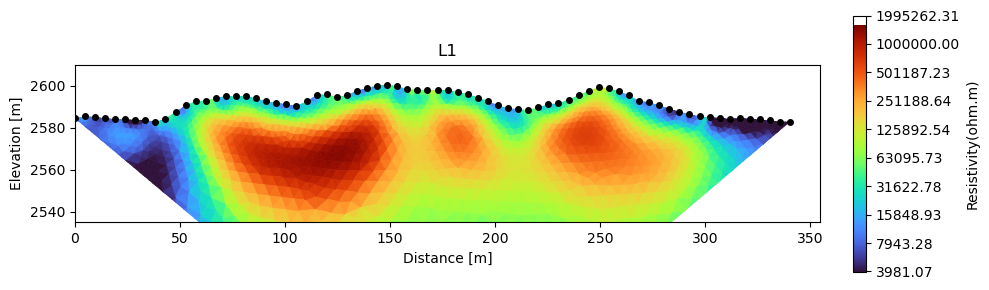

In [56]:
# plot the results
fig, ax = plt.subplots(figsize=(10,3), sharex=True)
k.showResults(index=0, ax=ax,
                 attr='Resistivity(log10)', vmin=3.6, vmax=6.2,
                 clipCorners=True,
                 #contour=True,
                 color_map='turbo', sens=False
                )
ax.set_xlim(0, len_x)
ax.set_ylim(2535, 2610)
ax.set_title(filename)
fig.tight_layout()
#fig.savefig(outputdir +filename +'_model.png', #transparent = True,
           # dpi=200)

In [ ]:
invdir = '../inv'
k.saveVtks(dirname=invdir)